In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time
from reservoir import Reservoir
import data_utils

%load_ext autoreload
%autoreload 2
%aimport reservoir
%matplotlib inline
import matplotlib.pyplot as plt

# TODO: check if no boundery changes performance
def load_input_1(path, n_seq=1):
    T_3D = np.load(path)[1:, :, :] # skipping the boundary layer
    x_dim, y_dim, sequence_length = T_3D.shape
    T_2D = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
    T_2D_norm = np.tanh((T_2D-np.mean(T_2D))/np.std(T_2D))
    T_2D_norm = np.tile(T_2D_norm, (n_seq, 1, 1))
    return T_2D_norm

def load_input_2(path, n_seq=1):
    T_3D = np.load(path)[1:, :, :] # skipping the boundary layer
    T_2D = np.transpose(T_3D, axes=(0, 2, 1))
    T_2D_norm = np.tanh((T_2D-np.mean(T_2D))/np.std(T_2D))
    T_2D_norm = np.tile(T_2D_norm, (n_seq, 1, 1))
    return T_2D_norm

In [3]:
# Input data

train_data = load_input_2("2D_convection_datasets/x_y_temperature_deltaT_4.npy", n_seq = 2)
n_sequence, sequence_length, spatial_points = train_data.shape

b = Reservoir(n_res=2000, res_scale=1, res_encoding='phase', res_enc_param=1.5*np.pi,
              input_scale=1, input_encoding='phase', input_enc_param = 1.5*np.pi,
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=1,
              parallel_runs=n_sequence,  bias_scale=0.2, leak_rate=0.15,
              pred_horizon=1, rec_pred_steps=1, forget = 100,
              train_method='ridge', train_param=1e3, verbose=1
             )

# Algorithm training
b.fit(train_data);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.857020378112793 s
100%|██████████| 1201/1201 [01:26<00:00, 14.06it/s]
Reservoir iterations complete. 		Elapsed time: 86.14589476585388 s
Training complete. 			Elapsed time: 5.73761510848999 s
Training score: 0.9746511999105084


In [8]:
# testing data
test_data = load_input_2("2D_convection_datasets/x_y_temperature_deltaT_8.npy", n_seq = 1)
n_sequence, sequence_length, spatial_points = test_data.shape

# Algorithm testing
b.parallel_runs = n_sequence
pred_output, valid_score = b.predict_and_score(test_data, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.20057988166809082 s
100%|██████████| 1201/1201 [00:45<00:00, 22.38it/s]
Reservoir iterations complete. 		Elapsed time: 45.379703998565674 s
Testing complete. 			Elapsed time: 1.2102160453796387 s
Testing score: 0.8509622941791883


kldsakdnkjenmkewk

In [ ]:
from sklearn.model_selection import GridSearchCV

train_data = load_input_1("2D_convection_datasets/x_y_temperature_deltaT_4.npy", n_seq = 30)
n_sequence, sequence_length, spatial_points = train_data.shape

b = Reservoir(n_res=4000, res_scale=1, res_encoding='phase', res_enc_param=1.5*np.pi,
              input_scale=1, input_encoding='phase', input_enc_param = 1.5*np.pi,
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=1,
              parallel_runs=n_sequence,  bias_scale=0.2, leak_rate=0.15,
              pred_horizon=1, rec_pred_steps=1, forget = 100,
              train_method='ridge', train_param=1e3, verbose=1
             )
params = [
    {'res_scale': np.array([.5, 1, 2]),
     'input_scale': np.array([.5, 1, 2]),
     'bias_scale': np.array([0, 0.5, 1, 2]),
    'train_param': np.array([1e-2, 1e0, 1e2, 1e4])}
]
grid_search = GridSearchCV(estimator=b, param_grid=params, return_train_score=True, cv=3, verbose=2, n_jobs=2)
grid_search.fit(train_data)

print(grid_search.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 191.1min


In [ ]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(train_data[0].reshape((-1, 25, 101))[600], cmap='inferno')plt.rcParams.update({'font.size': 16})
plt.title('Targetted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Train.png', bbox_inches='tight', dpi=400)

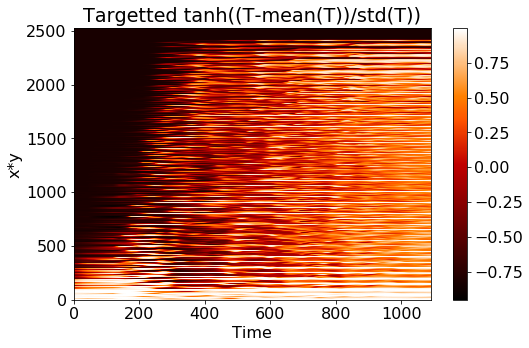

In [107]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_concat[0, b.forget+10:, :].T, cmap='gist_heat')
plt.rcParams.update({'font.size': 16})
plt.title('Targetted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Train.png', bbox_inches='tight', dpi=400)

<function matplotlib.pyplot.show(*args, **kw)>

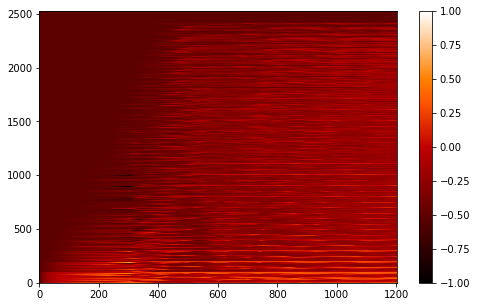

In [8]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_norm[0].T, cmap='gist_heat')
plt.colorbar(im)
plt.show

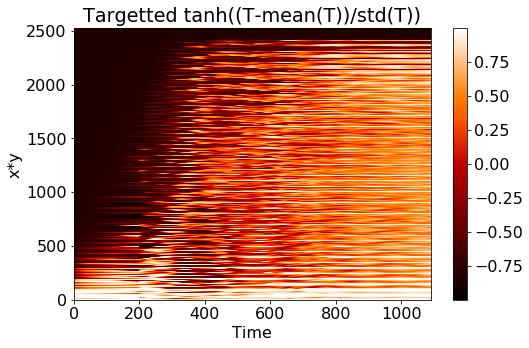

In [105]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_concat[0, b.forget+10:, :].T, cmap='gist_heat')
plt.rcParams.update({'font.size': 16})
plt.title('Targetted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Test.png', bbox_inches='tight', dpi=400)

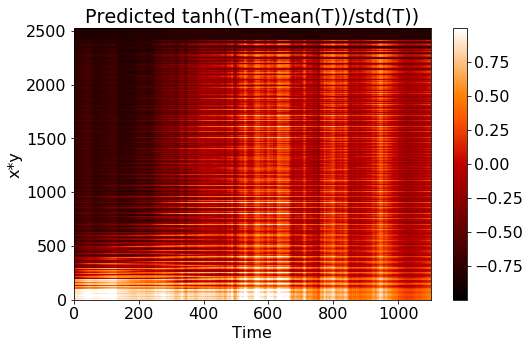

In [104]:
P = pred_output[:, 0*spatial_points:1*spatial_points]
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(P.T, cmap='gist_heat',vmin=np.min(T_2D_concat), vmax=np.max(T_2D_concat))
plt.rcParams.update({'font.size': 16})
plt.title('Predicted tanh((T-mean(T))/std(T))')
plt.ylabel('x*y')
plt.xlabel('Time')
plt.colorbar(im)
plt.show
plt.savefig('Prediction.png', bbox_inches='tight', dpi=400)

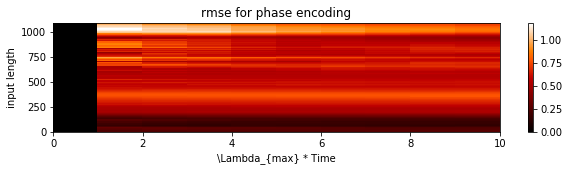

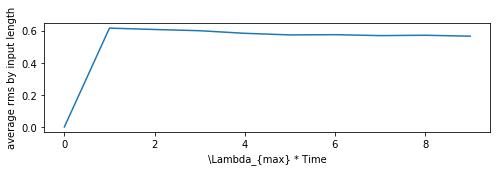

In [13]:
# prediction RMSE
total_pred = b.pred_horizon*b.rec_pred_steps
true_data = T_2D_concat[:, b.forget:, :]
true_data_std = np.std(true_data) # think about better normalization
true_data_norm = data_utils.roll_and_concat(true_data, roll_num=b.pred_horizon)[0]/true_data_std
pred_output_norm = pred_output/true_data_std
length_input = pred_output.shape[0] - total_pred
rmse = np.zeros((length_input, total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, total_pred):
        d1 = pred_output_norm[n_input, :].reshape(-1, spatial_points)[0:n_pred,:]
        d2 = true_data_norm[n_input:n_input+n_pred, 0:spatial_points]
        
        rmse[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))

plt.figure(1,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(np.mean(rmse[:,:], axis=0))
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rmse[:,1:], axis=0)/length_input)

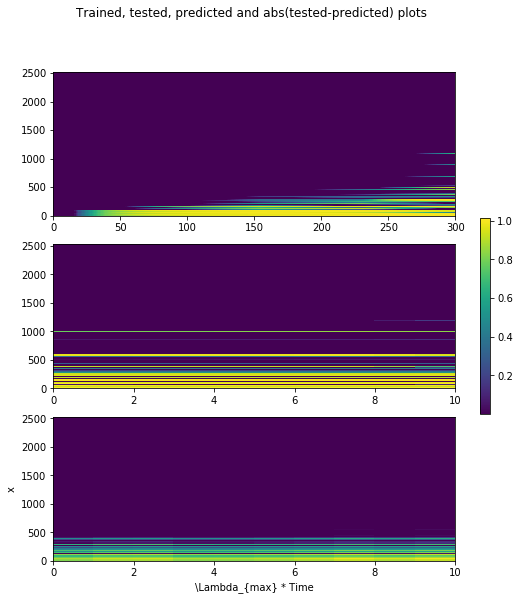

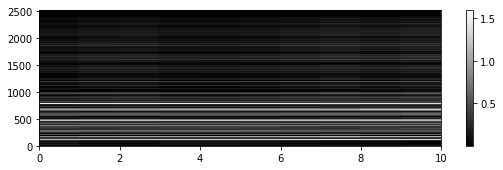

In [15]:
total_pred = b.pred_horizon*b.rec_pred_steps
n_input = 200 #round(pred_output.shape[0]/2-300)
input_data = T_2D_concat[0, :n_input+b.forget, :]
prediction = pred_output[n_input, :].reshape(-1, spatial_points)
targetted_data = T_2D_concat[0, n_input+b.forget:n_input+b.forget+total_pred, :]

vmax = np.amax(abs(np.concatenate((targetted_data, input_data, prediction))))
vmin = np.min(abs(np.concatenate((targetted_data, input_data, prediction))))

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    im=axs[i].pcolormesh(datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')